## Base BERT Model

## Model Training and Evaluation

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2


Training: 100%|███████████████████████████| 1240/1240 [1:40:01<00:00,  4.84s/it]


Train loss: 0.2942 | Train accuracy: 0.8969


Evaluating: 100%|███████████████████████████| 310/310 [1:00:51<00:00, 11.78s/it]


Validation accuracy: 0.9141
Classification Report:
               precision    recall  f1-score   support

           0     0.5426    0.1759    0.2656       290
           1     0.9358    0.9656    0.9504      3832
           2     0.8581    0.9341    0.8945       835

    accuracy                         0.9141      4957
   macro avg     0.7788    0.6918    0.7035      4957
weighted avg     0.8997    0.9141    0.9009      4957


Epoch 2/2


Training: 100%|███████████████████████████| 1240/1240 [1:45:42<00:00,  5.11s/it]


Train loss: 0.2097 | Train accuracy: 0.9244


Evaluating: 100%|█████████████████████████████| 310/310 [06:34<00:00,  1.27s/it]


Validation accuracy: 0.9129
Classification Report:
               precision    recall  f1-score   support

           0     0.5459    0.3483    0.4253       290
           1     0.9460    0.9509    0.9485      3832
           2     0.8478    0.9341    0.8889       835

    accuracy                         0.9129      4957
   macro avg     0.7799    0.7444    0.7542      4957
weighted avg     0.9061    0.9129    0.9078      4957



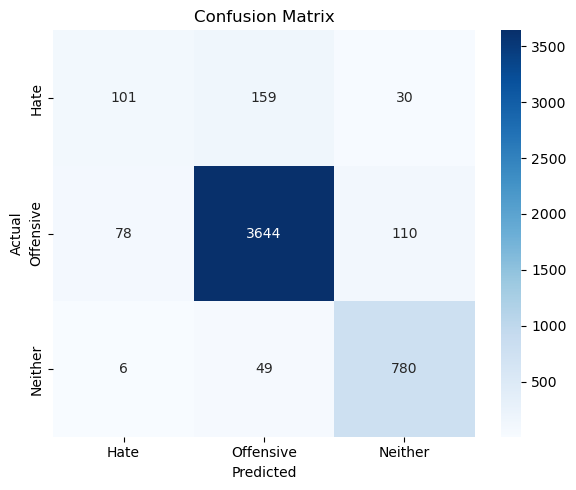

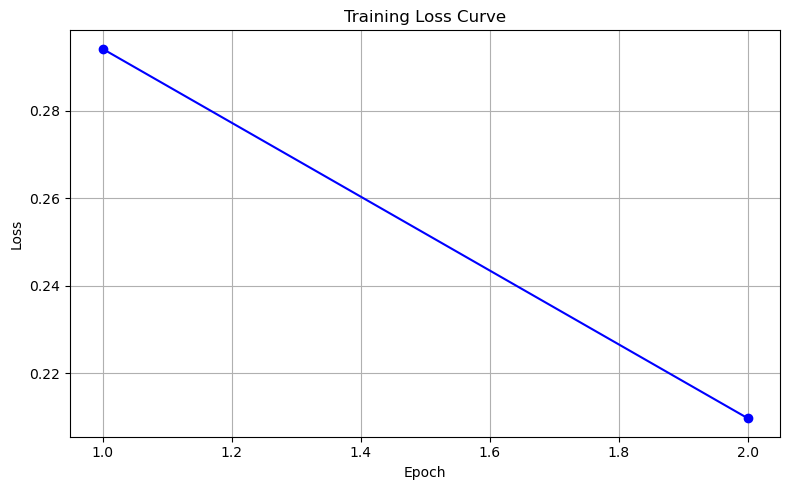

Prediction for 'I have hatred towards my brother': Class 2
Prediction for 'My brother is decent at football': Class 2
Prediction for 'This is so crap': Class 1


In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load and prepare dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    texts = df['tweet'].values
    labels = df['class'].values  # Assuming 0, 1, 2 for three classes
    return train_test_split(texts, labels, test_size=0.2, random_state=42)

# 2. Create custom dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 3. Training function
def train_model(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        total_loss += loss.item()
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)
        
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples
    return avg_loss, accuracy.item()

# 4. Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, report, cm

# 5. Main function
def main():
    # Parameters
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 2
    LEARNING_RATE = 2e-5
    
    # Load dataset (replace with your dataset path)
    train_texts, test_texts, train_labels, test_labels = load_dataset('labeled_data.csv')
    
    # Initialize BERT tokenizer and model with 3 classes
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model = model.to(device)
    
    # Create data loaders
    train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    test_dataset = HateSpeechDataset(test_texts, test_labels, tokenizer, MAX_LEN)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    train_losses = []

    
    # Training loop
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
        train_loss, train_acc = train_model(model, train_loader, optimizer, device)
        train_losses.append(train_loss)

        print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
    
        val_acc, val_report, cm = evaluate_model(model, test_loader, device)
        print(f"Validation accuracy: {val_acc:.4f}")
        print("Classification Report:\n", val_report)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Hate", "Offensive", "Neither"], yticklabels=["Hate", "Offensive", "Neither"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plotting training loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', color='b')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    # Example prediction function for 3 classes
    def predict_class(text):
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        _, prediction = torch.max(outputs.logits, dim=1)
        class_names = ["Class 0", "Class 1", "Class 2"]  # Replace with your actual class names
        return class_names[prediction.item()]
    
    # Test predictions
    test_texts = [
        "I have hatred towards my brother",
        "My brother is decent at football",
        "This is so crap"
    ]
    
    for text in test_texts:
        print(f"Prediction for '{text}': {predict_class(text)}")

if __name__ == "__main__":
    main()

## BERTweet Model

## Model Training and Evaluation

Starting BERTweet hate speech detection training...
Using device: cpu


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Confusion Matrix
1,0.299700,0.276832,0.914263,0.909651,0.907563,0.914263,[[ 103 156 31] [ 82 3651 99] [ 10 47 778]]
2,0.104200,0.300106,0.912447,0.909277,0.906962,0.912447,[[ 115 156 19] [ 92 3667 73] [ 21 73 741]]


Epoch 1 - Training loss: 0.2997
               precision    recall  f1-score   support

     Hate (0)       0.53      0.36      0.42       290
Offensive (1)       0.95      0.95      0.95      3832
  Neither (2)       0.86      0.93      0.89       835

     accuracy                           0.91      4957
    macro avg       0.78      0.75      0.76      4957
 weighted avg       0.91      0.91      0.91      4957

Epoch 2 - Training loss: 0.1042
               precision    recall  f1-score   support

     Hate (0)       0.50      0.40      0.44       290
Offensive (1)       0.94      0.96      0.95      3832
  Neither (2)       0.89      0.89      0.89       835

     accuracy                           0.91      4957
    macro avg       0.78      0.75      0.76      4957
 weighted avg       0.91      0.91      0.91      4957



               precision    recall  f1-score   support

     Hate (0)       0.50      0.40      0.44       290
Offensive (1)       0.94      0.96      0.95      3832
  Neither (2)       0.89      0.89      0.89       835

     accuracy                           0.91      4957
    macro avg       0.78      0.75      0.76      4957
 weighted avg       0.91      0.91      0.91      4957



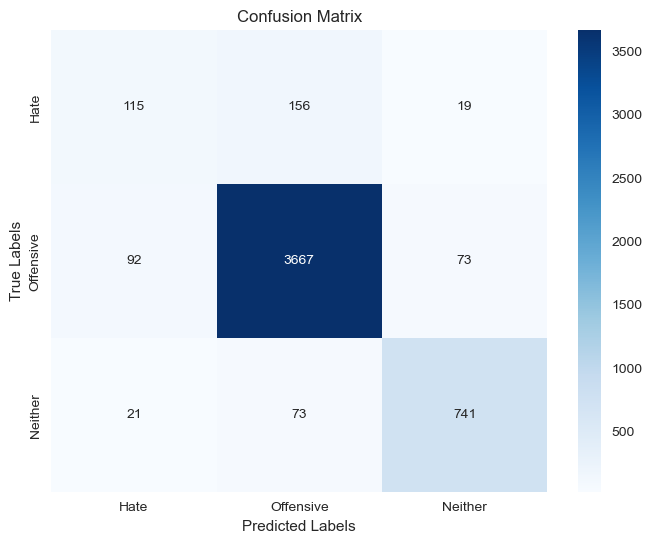

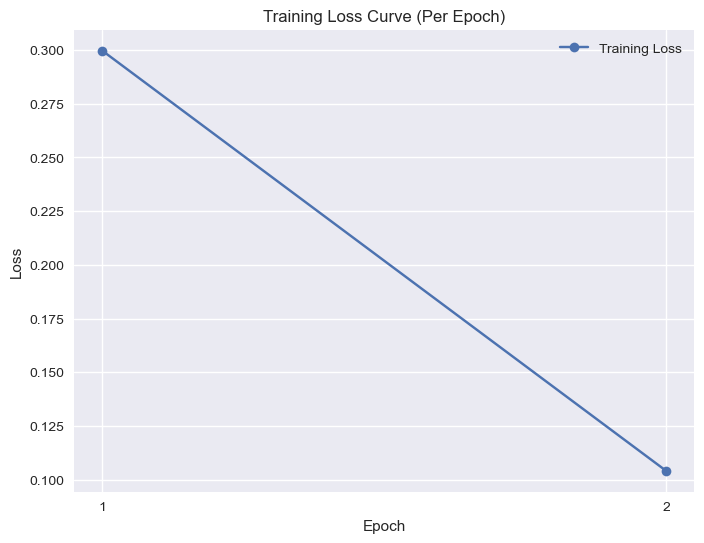

Training completed successfully!

Test Predictions:
Text: I have hatred towards my brother
Prediction: Hate (0) (confidence: 0.4681)
Probabilities:
  Hate (0): 0.4681
  Offensive (1): 0.1149
  Neither (2): 0.4170
--------------------------------------------------------------------------------
Text: My brother is decent at football
Prediction: Neither (2) (confidence: 0.9924)
Probabilities:
  Hate (0): 0.0031
  Offensive (1): 0.0045
  Neither (2): 0.9924
--------------------------------------------------------------------------------
Text: This is so crap
Prediction: Neither (2) (confidence: 0.9682)
Probabilities:
  Hate (0): 0.0058
  Offensive (1): 0.0260
  Neither (2): 0.9682
--------------------------------------------------------------------------------


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from transformers import TrainerCallback
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns  # for plotting the heatmap
import warnings
warnings.filterwarnings('ignore')

# Lists to store epoch-level metrics
epoch_train_losses = []
epoch_val_losses = []

# Configuration
MODEL_NAME = "vinai/bertweet-base"
DATASET_PATH = "labeled_data.csv"
RANDOM_SEED = 42
TEST_SIZE = 0.2
MAX_LENGTH = 128
BATCH_SIZE = 8
NUM_EPOCHS = 2
LEARNING_RATE = 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx].lower()
        text = " ".join(self.tokenizer.tokenize(text))
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def load_and_prepare_data(tokenizer):
    df = pd.read_csv(DATASET_PATH)
    if 'tweet' not in df.columns or 'class' not in df.columns:
        raise ValueError("CSV must contain 'tweet' and 'class' columns")

    # Keep original 3-class labels (0, 1, 2)
    df['class'] = df['class'].astype(int)
    
    texts = df['tweet'].values
    labels = df['class'].values
    
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )
    
    train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
    val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
    
    return train_dataset, val_dataset

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # For multi-class classification, use 'weighted' or 'macro' average
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)
    
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Print classification report for more detailed metrics
    print(classification_report(labels, preds, target_names=['Hate (0)', 'Offensive (1)', 'Neither (2)']))
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

class EpochMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Get the training loss for the completed epoch
        # The log_history contains dictionaries of metrics
        # The last entry is the training metrics, the one before is validation
        if len(state.log_history) > 1:
            # Training loss is in the last entry
            train_loss = state.log_history[-1].get('loss', None)
            # Validation loss is in the second last entry
            val_loss = state.log_history[-2].get('eval_loss', None)
            
            if train_loss is not None:
                epoch_train_losses.append(train_loss)
                print(f"Epoch {int(state.epoch)} - Training loss: {train_loss:.4f}")
            if val_loss is not None:
                epoch_val_losses.append(val_loss)
                print(f"Epoch {int(state.epoch)} - Validation loss: {val_loss:.4f}")

def plot_loss_curve():
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_train_losses)+1), epoch_train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve (Per Epoch)')
    plt.xticks(range(1, len(epoch_train_losses)+1))
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, normalization=True)
    train_dataset, val_dataset = load_and_prepare_data(tokenizer)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3  # Now we have 3 classes
    ).to(device)
    
    training_args = TrainingArguments(
        output_dir="./temp_output",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
        save_strategy="no",
        save_total_limit=1,
        metric_for_best_model="eval_loss",
        logging_dir="./temp_logs",
        logging_steps=10,
        report_to="none",
        fp16=torch.cuda.is_available(),
        seed=RANDOM_SEED,
        load_best_model_at_end=False
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EpochMetricsCallback()]
    )
    
    trainer.train()

    # Get the confusion matrix from evaluation logs
    eval_results = trainer.evaluate()
    cm = eval_results['eval_confusion_matrix']
    
    # Plot the confusion matrix heatmap with 3 classes
    plot_confusion_matrix(cm, labels=["Hate", "Offensive", "Neither"])
    
    return model, tokenizer

class BERTweetHateSpeechDetector:
    def __init__(self, model, tokenizer):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.tokenizer = tokenizer
        self.labels = ["Hate (0)", "Offensive (1)", "Neither (2)"]
    
    def preprocess_text(self, text):
        text = text.lower()
        return " ".join(self.tokenizer.tokenize(text))
    
    def predict(self, text, return_probabilities=False):
        processed_text = self.preprocess_text(text)
        inputs = self.tokenizer(
            processed_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        probabilities = probabilities.cpu().numpy().flatten()
        
        predicted_label_idx = np.argmax(probabilities)
        predicted_label = self.labels[predicted_label_idx]
        confidence = probabilities[predicted_label_idx]
        
        results = {
            "text": text,
            "label": predicted_label,
            "confidence": float(confidence)
        }
        
        if return_probabilities:
            results["probabilities"] = {
                label: float(prob) for label, prob in zip(self.labels, probabilities)
            }
        
        return results

# Main Execution
if __name__ == "__main__":
    print("Starting BERTweet hate speech detection training...")
    print(f"Using device: {device}")
    
    try:
        model, tokenizer = train_model()
        plot_loss_curve()
        print("Training completed successfully!")
        
        detector = BERTweetHateSpeechDetector(model, tokenizer)
        
        test_texts = [
            "I have hatred towards my brother",
            "My brother is decent at football",
            "This is so crap"
        ]
        
        print("\nTest Predictions:")
        for text in test_texts:
            result = detector.predict(text, return_probabilities=True)
            print(f"Text: {result['text']}")
            print(f"Prediction: {result['label']} (confidence: {result['confidence']:.4f})")
            if "probabilities" in result:
                print("Probabilities:")
                for label, prob in result["probabilities"].items():
                    print(f"  {label}: {prob:.4f}")
            print("-" * 80)
            
    except Exception as e:
        print(f"Error during training: {str(e)}")

## RoBERTa Model

## Model Training and Evaluation

/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spacyenv/lib/python3.12/lib-dynload/../../libjpeg.9.dylib'


Epoch 1 Summary:
Training Loss: 0.3057
Training Accuracy: 0.8963
Validation Accuracy: 0.9090

Validation Metrics:
Class-wise Precision: [0.45454545 0.92305777 0.88425926]
Class-wise Recall: [0.11784512 0.97629708 0.88528389]
Class-wise F1: [0.18716578 0.94893127 0.88477128]
Macro Avg Precision: 0.7540
Macro Avg Recall: 0.6598
Macro Avg F1: 0.6736
Weighted Avg Precision: 0.8882
Weighted Avg Recall: 0.9090
Weighted Avg F1: 0.8921



Epoch 2/2: 100%|████████████████| 930/930 [3:42:04<00:00, 14.33s/it, loss=0.664]



Epoch 2 Summary:
Training Loss: 0.2146
Training Accuracy: 0.9233
Validation Accuracy: 0.9163

Validation Metrics:
Class-wise Precision: [0.54736842 0.94223827 0.88188976]
Class-wise Recall: [0.35016835 0.96233869 0.90845886]
Class-wise F1: [0.42710472 0.95218241 0.89497717]
Macro Avg Precision: 0.7905
Macro Avg Recall: 0.7403
Macro Avg F1: 0.7581
Weighted Avg Precision: 0.9081
Weighted Avg Recall: 0.9163
Weighted Avg F1: 0.9108



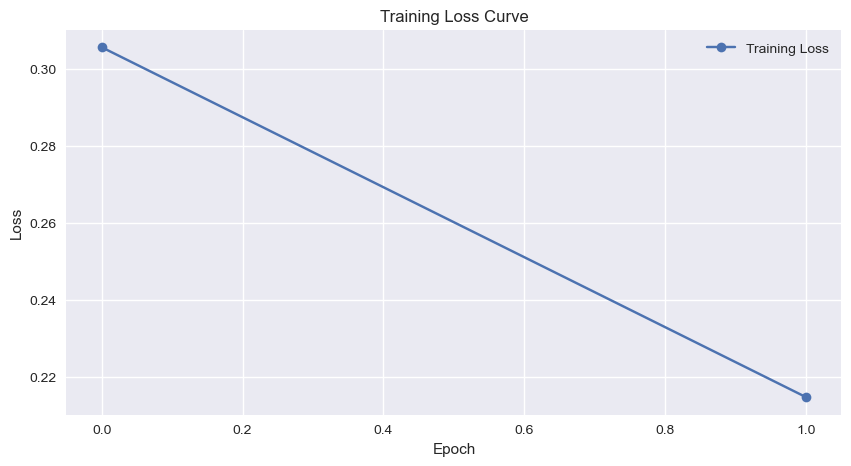

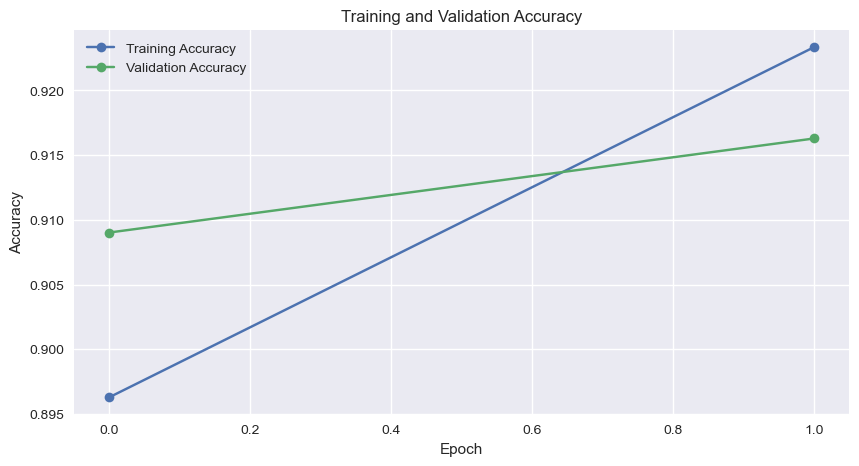


Final Test Set Performance:
              precision    recall  f1-score   support

     Class 0     0.5029    0.3164    0.3884       275
     Class 1     0.9429    0.9560    0.9494      3867
     Class 2     0.8667    0.9178    0.8915       815

    accuracy                         0.9143      4957
   macro avg     0.7708    0.7301    0.7431      4957
weighted avg     0.9059    0.9143    0.9088      4957


Detailed Test Metrics:
Accuracy: 0.9143
Class-wise Precision: [0.5029 0.9429 0.8667]
Class-wise Recall: [0.3164 0.956  0.9178]
Class-wise F1: [0.3884 0.9494 0.8915]
Macro Avg Precision: 0.7708
Macro Avg Recall: 0.7301
Macro Avg F1: 0.7431
Weighted Avg Precision: 0.9059
Weighted Avg Recall: 0.9143
Weighted Avg F1: 0.9088


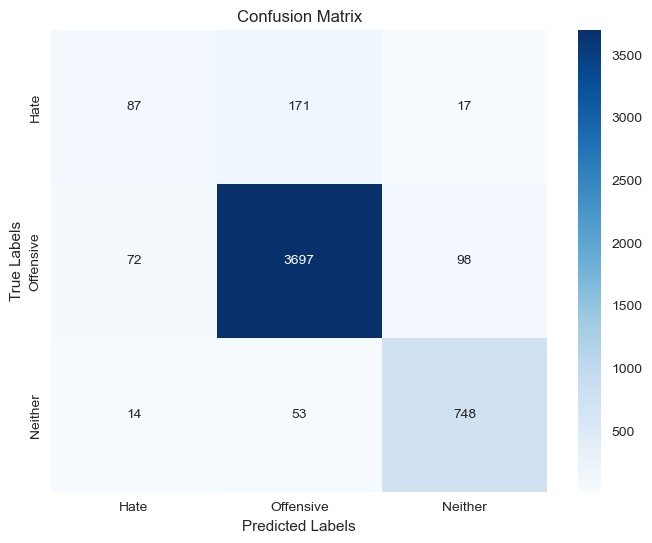


Test Predictions:
--------------------------------------------------------------------------------
Text: I have hatred towards my brother
Predicted Class: 2 (Neither (2))
Confidence: 0.6589
Probabilities:
  Hate (0): 0.1618
  Offensive (1): 0.1793
  Neither (2): 0.6589
--------------------------------------------------------------------------------
Text: My brother is decent at football
Predicted Class: 2 (Neither (2))
Confidence: 0.9893
Probabilities:
  Hate (0): 0.0037
  Offensive (1): 0.0070
  Neither (2): 0.9893
--------------------------------------------------------------------------------
Text: This is so crap
Predicted Class: 1 (Offensive (1))
Confidence: 0.8576
Probabilities:
  Hate (0): 0.0536
  Offensive (1): 0.8576
  Neither (2): 0.0887
--------------------------------------------------------------------------------


In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm

# Initialize matplotlib style
plt.style.use('seaborn-v0_8')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

model_path = './roberta-base-local'
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=3)

# Load dataset
df = pd.read_csv('labeled_data.csv')
df = df[['tweet', 'class']].dropna()
df['class'] = df['class'].astype(int)

# Split dataset (60% train, 20% validation, 20% test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['tweet'].tolist(), df['class'].tolist(), test_size=0.4, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Tokenize datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# Create datasets and dataloaders
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 2
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_accuracies = []

def evaluate_model(model, data_loader):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    # Calculate all metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predictions, average=None, labels=[0, 1, 2]
    )
    macro_avg = {
        'precision': np.mean(precision),
        'recall': np.mean(recall),
        'f1': np.mean(f1)
    }
    weighted_avg = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )[:3]
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'macro_avg': macro_avg,
        'weighted_avg': weighted_avg,
        'confusion_matrix': cm,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    train_predictions, train_true_labels = [], []
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        
        # Get predictions for accuracy calculation
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        train_predictions.extend(preds.cpu().numpy())
        train_true_labels.extend(batch['labels'].cpu().numpy())
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    # Calculate metrics at the end of each epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = accuracy_score(train_true_labels, train_predictions)
    val_results = evaluate_model(model, val_loader)
    
    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_results['accuracy'])
    
    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_results['accuracy']:.4f}")
    
    # Print detailed validation metrics
    print("\nValidation Metrics:")
    print(f"Class-wise Precision: {val_results['precision']}")
    print(f"Class-wise Recall: {val_results['recall']}")
    print(f"Class-wise F1: {val_results['f1']}")
    print(f"Macro Avg Precision: {val_results['macro_avg']['precision']:.4f}")
    print(f"Macro Avg Recall: {val_results['macro_avg']['recall']:.4f}")
    print(f"Macro Avg F1: {val_results['macro_avg']['f1']:.4f}")
    print(f"Weighted Avg Precision: {val_results['weighted_avg'][0]:.4f}")
    print(f"Weighted Avg Recall: {val_results['weighted_avg'][1]:.4f}")
    print(f"Weighted Avg F1: {val_results['weighted_avg'][2]:.4f}\n")

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png')
plt.show()

# Final evaluation on test set
test_results = evaluate_model(model, test_loader)

# Print comprehensive classification report
print("\nFinal Test Set Performance:")
print(classification_report(
    test_results['true_labels'], 
    test_results['predictions'], 
    target_names=['Class 0', 'Class 1', 'Class 2'],
    digits=4
))

# Print detailed metrics
print("\nDetailed Test Metrics:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Class-wise Precision: {np.round(test_results['precision'], 4)}")
print(f"Class-wise Recall: {np.round(test_results['recall'], 4)}")
print(f"Class-wise F1: {np.round(test_results['f1'], 4)}")
print(f"Macro Avg Precision: {test_results['macro_avg']['precision']:.4f}")
print(f"Macro Avg Recall: {test_results['macro_avg']['recall']:.4f}")
print(f"Macro Avg F1: {test_results['macro_avg']['f1']:.4f}")
print(f"Weighted Avg Precision: {test_results['weighted_avg'][0]:.4f}")
print(f"Weighted Avg Recall: {test_results['weighted_avg'][1]:.4f}")
print(f"Weighted Avg F1: {test_results['weighted_avg'][2]:.4f}")

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_results['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=["Hate", "Offensive", "Neither"],
            yticklabels=["Hate", "Offensive", "Neither"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()# Test prediction function


def predict_sentiment(texts, model, tokenizer):
    model.eval()
    predictions = []
    
    for text in texts:
        # Tokenize the input text
        inputs = tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            pred_class = torch.argmax(logits, dim=-1).item()
            confidence = torch.max(probs).item()
        
        # Get class label
        class_labels = ['Hate (0)', 'Offensive (1)', 'Neither (2)']
        predicted_label = class_labels[pred_class]
        
        predictions.append({
            'text': text,
            'predicted_class': pred_class,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'probabilities': {
                'Hate (0)': probs[0][0].item(),
                'Offensive (1)': probs[0][1].item(),
                'Neither (2)': probs[0][2].item()
            }
        })
    
    return predictions

# Example texts to predict
test_texts = [
    "I have hatred towards my brother",
    "My brother is decent at football",
    "This is so crap"
]

# Make predictions
predictions = predict_sentiment(test_texts, model, tokenizer)

# Print predictions
print("\nTest Predictions:")
print("-" * 80)
for pred in predictions:
    print(f"Text: {pred['text']}")
    print(f"Predicted Class: {pred['predicted_class']} ({pred['predicted_label']})")
    print(f"Confidence: {pred['confidence']:.4f}")
    print("Probabilities:")
    print(f"  Hate (0): {pred['probabilities']['Hate (0)']:.4f}")
    print(f"  Offensive (1): {pred['probabilities']['Offensive (1)']:.4f}")
    print(f"  Neither (2): {pred['probabilities']['Neither (2)']:.4f}")
    print("-" * 80)

## Unknown Text Prediction and Censoring of Hate and Offensive Text

In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk
import torch
from transformers import BertTokenizer, BertForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer

# Download NLTK resources (run once)
nltk.download('punkt')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_dataset(file_path):
    """Load dataset from CSV file"""
    try:
        df = pd.read_csv(file_path)
        return df['Content'].values  # Assuming 'text' column exists
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return []

def predict_texts(model, tokenizer, texts, device, max_len=128):
    """Make predictions using BERT model"""
    model.eval()
    predictions = []
    
    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        _, pred = torch.max(outputs.logits, dim=1)
        predictions.append(pred.item())
    
    return predictions

def filter_offensive_words(text, offensive_words):
    """Filter out offensive words from text with different patterns based on word length"""
    filtered_words = []
    words = word_tokenize(text)
    for word in words:
        lower_word = word.lower()
        if lower_word not in offensive_words:
            filtered_words.append(word)
        else:
            if len(word) < 5:
                # For short words: first letter followed by stars
                filtered_word = word[0] + '*' * (len(word) - 1)
                filtered_words.append(filtered_word)
            else:
                # For longer words: first letter, stars, last letter
                filtered_word = word[0] + '*' * (len(word) - 2) + word[-1]
                filtered_words.append(filtered_word)
    return ' '.join(filtered_words)

# Main function
def main():
    # Configuration
    DATASET_PATH = 'HateSpeechDataset.csv'
    SAMPLE_SIZE = 100
    MAX_LEN = 128
    
    # Define offensive words
    OFFENSIVE_WORDS = {
        'bitch', 'faggot', 'nigga', 'nigger', 'white', 'fuck', 'trash',
        'fag', 'hoe', 'fucking', 'shit', 'hate', 'pussy', 'retard', 'twat', 
        'asshole', 'bitch', 'damn', 'hell', 'motherfucker', 'cunt', 'slut', 'bullshit', 'vagina', 'retarded', 'nazi', 'chig chong'
    }
    
    # Load data
    print("Loading data...")
    texts = load_dataset(DATASET_PATH)
    sample_texts = texts[:SAMPLE_SIZE] if SAMPLE_SIZE else texts

    # Initialize BERT model for classification
    print("Initializing BERT model for classification...")
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    bert_model = bert_model.to(device)

   # Make predictions
    print("Making predictions...")
    predictions = predict_texts(bert_model, bert_tokenizer, sample_texts, device, MAX_LEN)
    
    # Process results
    results = []
    for text, pred in zip(sample_texts, predictions):
        if pred in [0, 1]:  # Hate speech or offensive
            filtered = filter_offensive_words(text, OFFENSIVE_WORDS)
        else:
            filtered = text
        
        results.append({
            'original_text': text,
            'predicted_class': pred,
            'filtered_text': filtered,
        })
    
    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv('predictions_with_filtering.csv', index=False)
    print("Results saved to predictions_with_filtering.csv")
    
    # Show samples
    print("\nSample predictions:")
    for i, row in results_df.head(5).iterrows():
        print(f"\nOriginal: {row['original_text']}")
        print(f"Class: {row['predicted_class']}")
        print(f"Filtered: {row['filtered_text']}")

if __name__ == "__main__":
    main()

/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spacyenv/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spacyenv/lib/python3.12/lib-dynload/../../libjpeg.9.dylib'

Loading data...
Initializing BERT model for classification...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Making predictions...
Results saved to predictions_with_filtering.csv

Sample predictions:

Original: denial of normal the con be asked to comment on tragedies an emotional retard
Class: 2
Filtered: denial of normal the con be asked to comment on tragedies an emotional retard

Original: just by being able to tweet this insufferable bullshit proves trump a nazi you vagina
Class: 0
Filtered: just by being able to tweet this insufferable b******t proves trump a n*** you v****a

Original: that is retarded you too cute to be single that is life
Class: 0
Filtered: that is r******d you too cute to be single that is life

Original: thought of a real badass mongol style declaration of war the attackers capture a citizen of the soon to be
Class: 2
Filtered: thought of a real badass mongol style declaration of war the attackers capture a citizen of the soon to be

Original: afro american basho
Class: 2
Filtered: afro american basho
